In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
import optuna
warnings.simplefilter(action="ignore")

In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [16]:
df = pd.read_csv("telco.csv")

In [17]:
def general_info (dataframe):
    print(15*"-","Shape",15*"-")
    print(dataframe.shape,"\n")
    print(15*"-","Variable Types",15*"-")
    print(dataframe.info(),"\n")
    print(15*"-","Statistics",15*"-")
    print(dataframe.describe().T,"\n")
    print(15*"-","Null Value",15*"-")
    print(dataframe.isnull().sum(),"\n")
    print(15*"-","Quantiles",15*"-")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1], numeric_only=True).T)

In [19]:
general_info(df)

--------------- Shape ---------------
(7043, 21) 

--------------- Variable Types ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   obje

In [20]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [21]:
# TotalCharges is object type. It should be numeric.
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [22]:
# Transforming Churn column to binary
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [23]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Gives the names of categorical, numerical and categorical but cardinal variables in the dataset.
    Note: Categorical variables include variables that looks like numerical but categorical.
    
    Parameters
    ------
        dataframe: dataframe
        cat_th: int, optional
                Threshold value for categorical variables that seem numerical.
        car_th: int, optional
                Threshold value for cardinal variables that seem categorical.

    Returns
    ------
        cat_cols: list
                Categorical values list.
        num_cols: list
                Numerical values list.
        cat_but_car: list
                Cardinal values list
    """
    
    # num_but_cat
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f'\033[1mObservations: {dataframe.shape[0]}\033[0m\n')
    print(f'\033[1mVariables: {dataframe.shape[1]}\033[0m\n')
    print(f'\033[1mcat_cols: {len(cat_cols)} - {cat_cols}\033[0m\n')
    print(f'\033[1mnum_cols: {len(num_cols)} - {num_cols}\033[0m\n')
    print(f'\033[1mcat_but_car: {len(cat_but_car)} - {cat_but_car}\033[0m\n')
    print(f'\033[1mnum_but_cat: {len(num_but_cat)} - {num_but_cat}\033[0m\n')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043

Variables: 21

cat_cols: 17 - ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn']

num_cols: 3 - ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_but_car: 1 - ['customerID']

num_but_cat: 2 - ['SeniorCitizen', 'Churn']



In [24]:
def cat_summary(dataframe, cat_list, plot=False):
    """
    This function is used to examine categorical variables.

    Parameters
    ------
        dataframe (dataframe): The dataframe to be processed.
        cat_list (list): Categorical variables list.
        plot (bool): If True, it shows the bar plot. Default is False.
    """
    for col in cat_list:
        print(f'\033[1m' +f'{col}'+'\033[0m')
        print(25*"-")
        print(pd.DataFrame({"Count": dataframe[col].value_counts(),
                            "Ratio": 100 * dataframe[col].value_counts() / len(dataframe)}))
        print("\n")
        if plot:
            sns.countplot(x=dataframe[col], hue=dataframe[col], data=dataframe)
            
            if col == "PaymentMethod":
                plt.xticks(rotation=20)
            plt.show()
            print("\n")

gender
-------------------------
        Count  Ratio
gender              
Male     3555 50.476
Female   3488 49.524




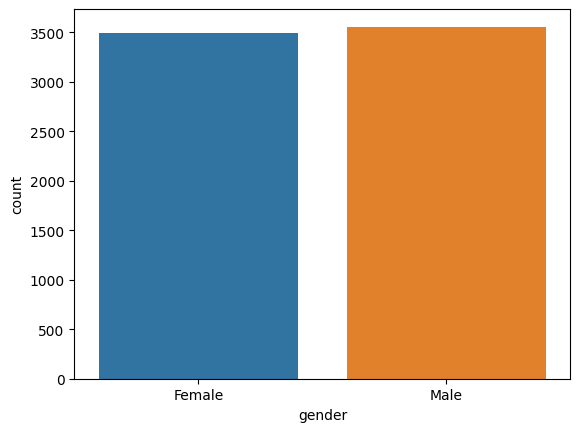



Partner
-------------------------
         Count  Ratio
Partner              
No        3641 51.697
Yes       3402 48.303




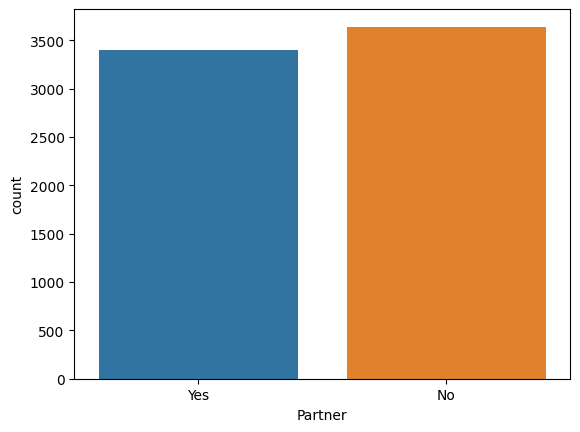



Dependents
-------------------------
            Count  Ratio
Dependents              
No           4933 70.041
Yes          2110 29.959




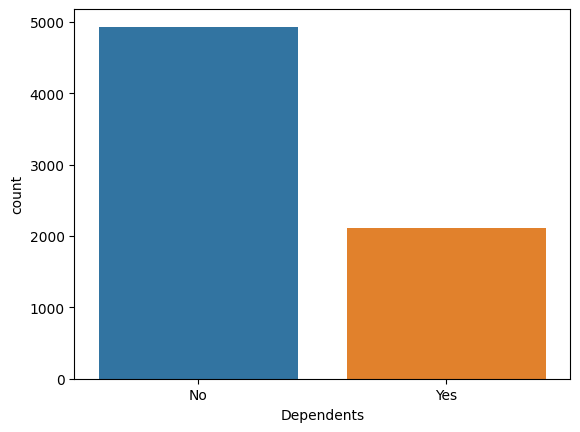



PhoneService
-------------------------
              Count  Ratio
PhoneService              
Yes            6361 90.317
No              682  9.683




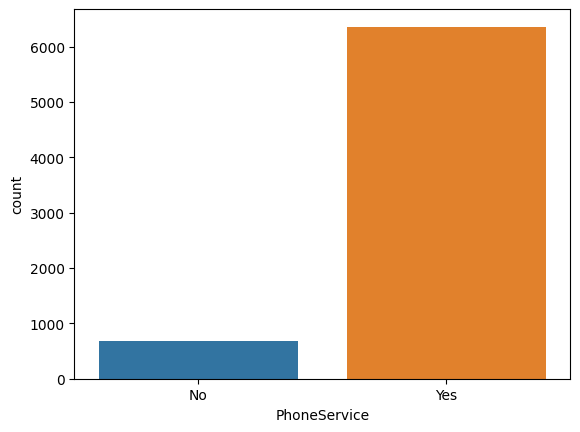



MultipleLines
-------------------------
                  Count  Ratio
MultipleLines                 
No                 3390 48.133
Yes                2971 42.184
No phone service    682  9.683




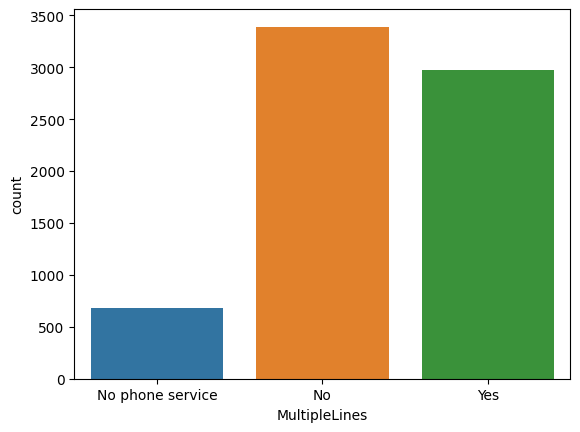



InternetService
-------------------------
                 Count  Ratio
InternetService              
Fiber optic       3096 43.959
DSL               2421 34.375
No                1526 21.667




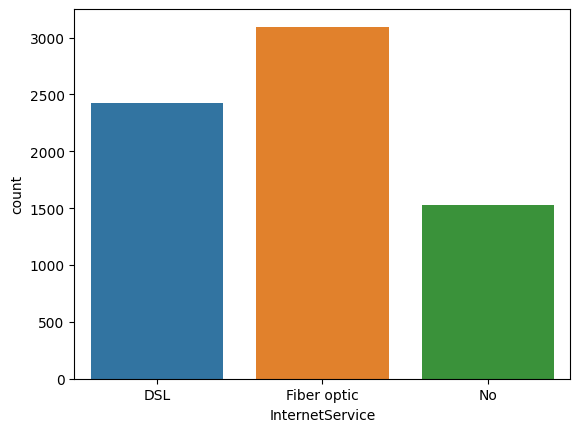



OnlineSecurity
-------------------------
                     Count  Ratio
OnlineSecurity                   
No                    3498 49.666
Yes                   2019 28.667
No internet service   1526 21.667




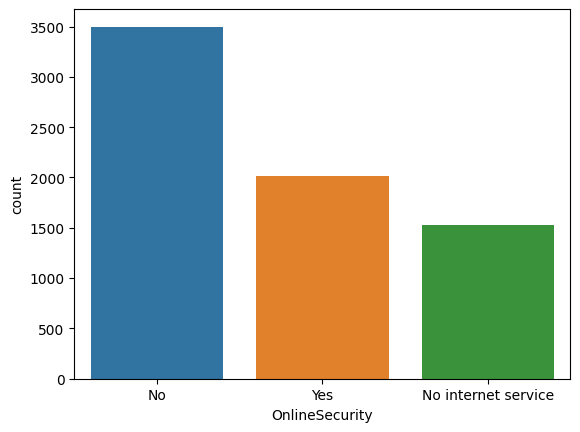



OnlineBackup
-------------------------
                     Count  Ratio
OnlineBackup                     
No                    3088 43.845
Yes                   2429 34.488
No internet service   1526 21.667




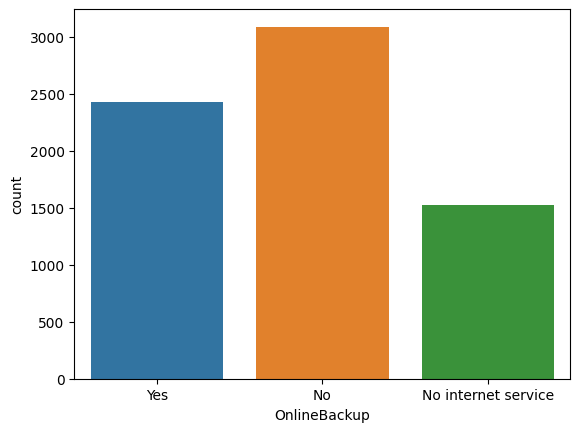



DeviceProtection
-------------------------
                     Count  Ratio
DeviceProtection                 
No                    3095 43.944
Yes                   2422 34.389
No internet service   1526 21.667




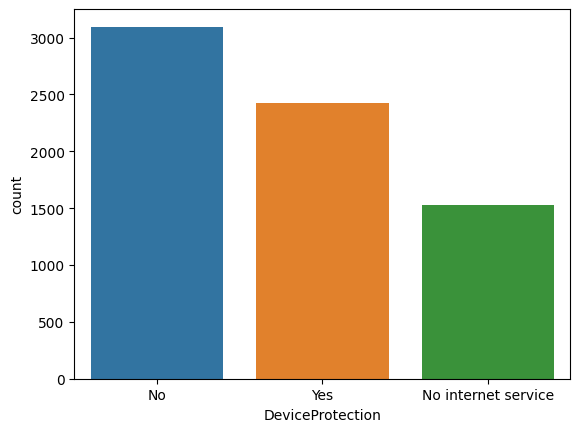



TechSupport
-------------------------
                     Count  Ratio
TechSupport                      
No                    3473 49.311
Yes                   2044 29.022
No internet service   1526 21.667




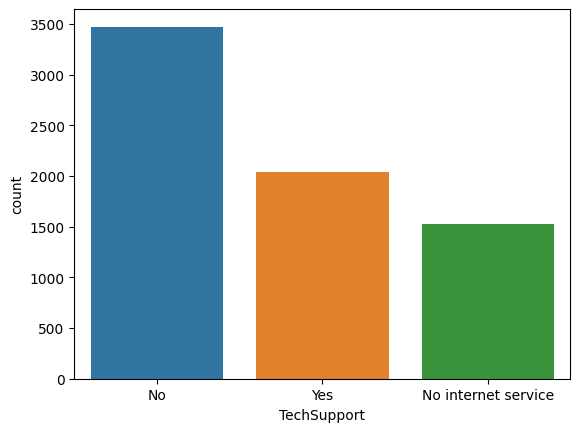



StreamingTV
-------------------------
                     Count  Ratio
StreamingTV                      
No                    2810 39.898
Yes                   2707 38.435
No internet service   1526 21.667




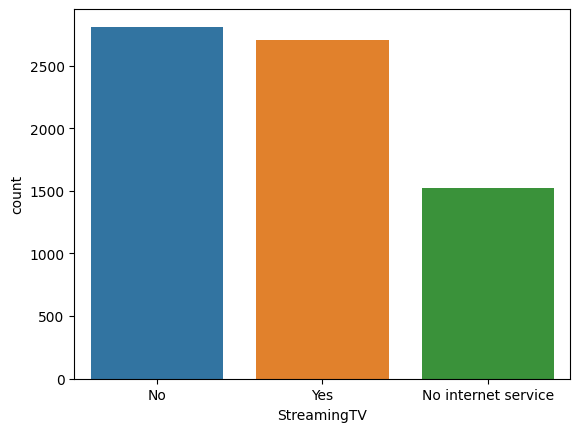



StreamingMovies
-------------------------
                     Count  Ratio
StreamingMovies                  
No                    2785 39.543
Yes                   2732 38.790
No internet service   1526 21.667




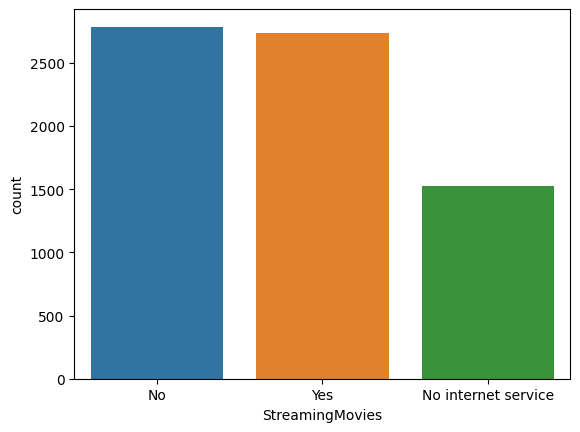



Contract
-------------------------
                Count  Ratio
Contract                    
Month-to-month   3875 55.019
Two year         1695 24.066
One year         1473 20.914




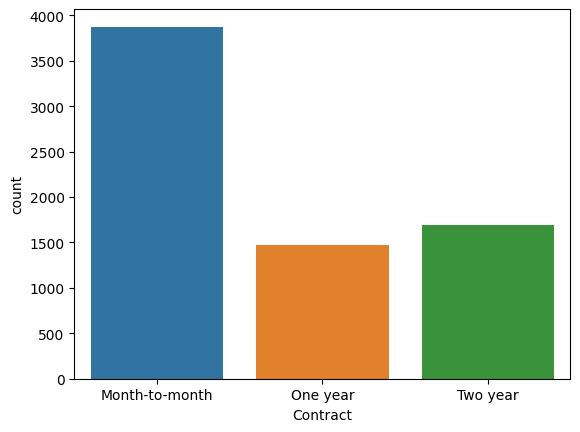



PaperlessBilling
-------------------------
                  Count  Ratio
PaperlessBilling              
Yes                4171 59.222
No                 2872 40.778




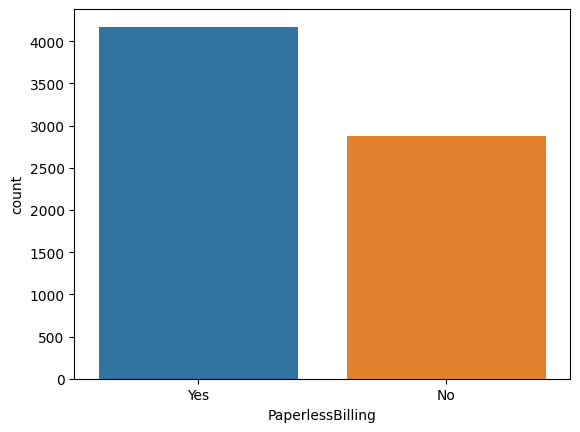



PaymentMethod
-------------------------
                           Count  Ratio
PaymentMethod                          
Electronic check            2365 33.579
Mailed check                1612 22.888
Bank transfer (automatic)   1544 21.922
Credit card (automatic)     1522 21.610




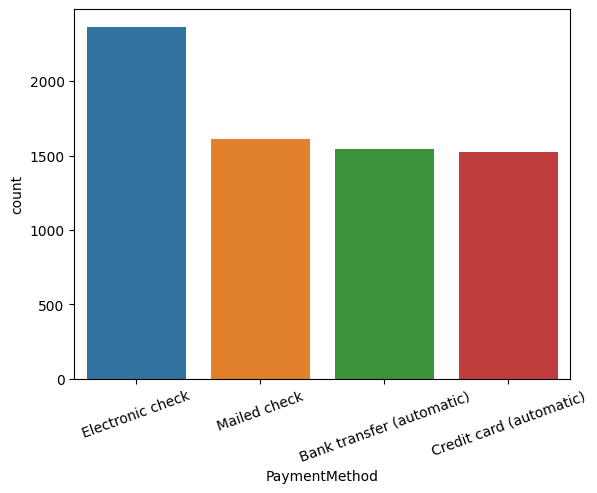



SeniorCitizen
-------------------------
               Count  Ratio
SeniorCitizen              
0               5901 83.785
1               1142 16.215




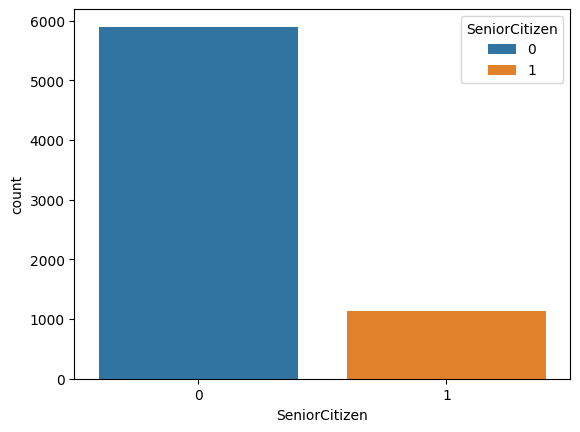



Churn
-------------------------
       Count  Ratio
Churn              
0       5174 73.463
1       1869 26.537




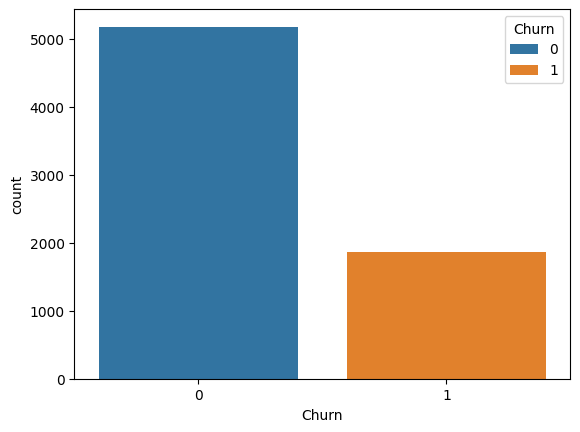

In [25]:
cat_summary(df, cat_cols, plot=True)

In [26]:
def num_summary(dataframe, numerical_col, plot=False):
    """
    This function is used to examine numerical variables.

    Parameters
    ------
        dataframe (dataframe): The dataframe to be processed.
        numerical_col (list): Numerical variables list.
        plot (bool): If True, it shows the histogram. Default is False.
    """
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

tenure
---------------
count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


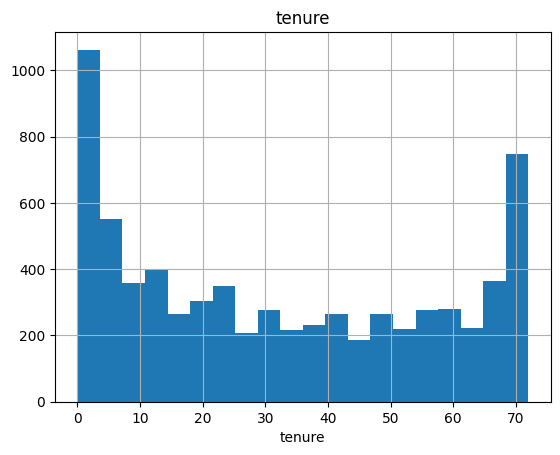

MonthlyCharges
---------------
count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


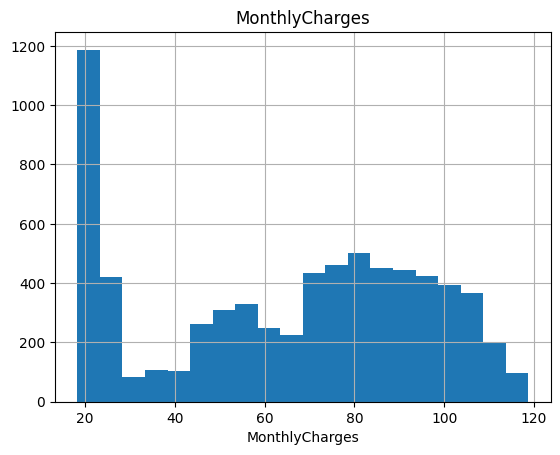

TotalCharges
---------------
count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


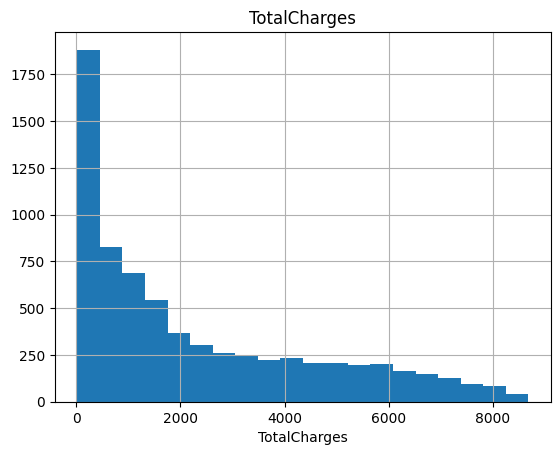

In [27]:
for col in num_cols:
    print(f'\033[1m' +f'{col}'+'\033[0m')
    print(15*"-")
    num_summary(df, col, plot=True)

In [28]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    """
    This function is used to examine the relationship between the target variable and the categorical variables.

    Parameters
    ------
        dataframe (dataframe): The dataframe to be processed.
        target (str): Target variable.
        categorical_col (str): Categorical variables list.
        plot (bool): If True, it shows the bar plot. Default is False.
    """
    print(f'\033[1m' +f'{categorical_col}'+'\033[0m')
    print(30*"-")
    print(pd.DataFrame({"Target Mean": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")
    if plot:
        sns.countplot(x=dataframe[col], hue=dataframe["Churn"], data=dataframe)
        plt.legend(title='Churn', loc='upper right', labels=['No', 'Yes'])
        if col == "PaymentMethod":
            plt.xticks(rotation=20)
        plt.show()
        print("\n")

gender
------------------------------
        Target Mean  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476




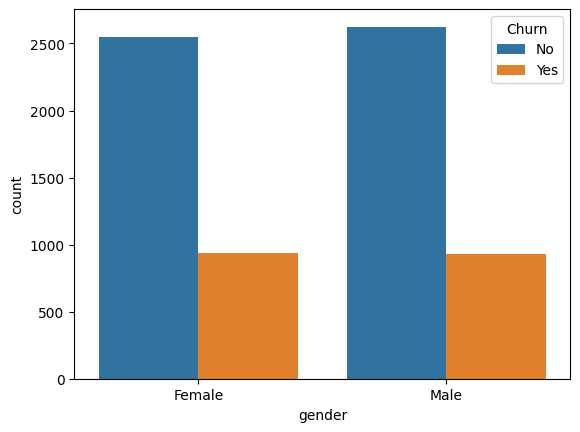



Partner
------------------------------
         Target Mean  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303




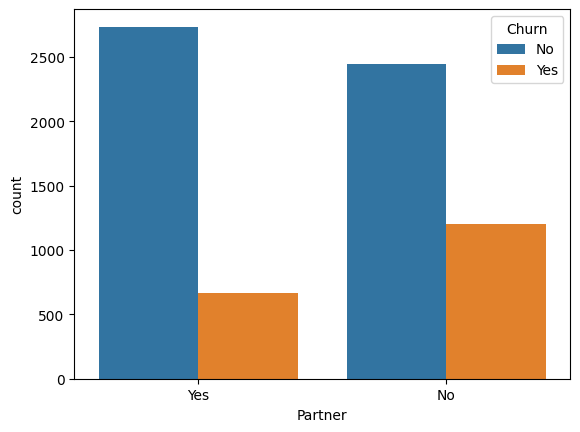



Dependents
------------------------------
            Target Mean  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959




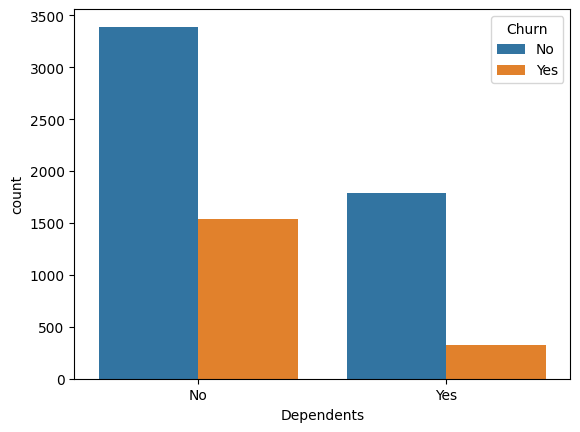



PhoneService
------------------------------
              Target Mean  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317




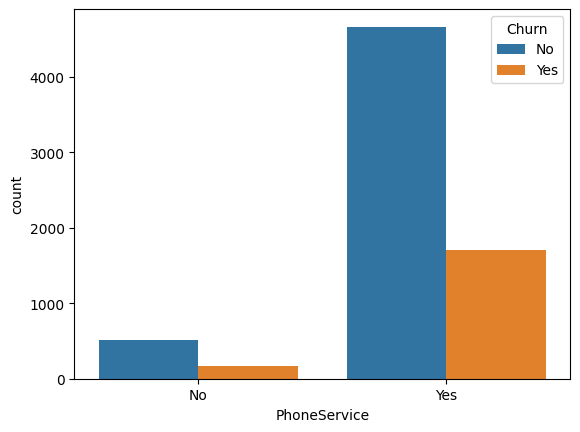



MultipleLines
------------------------------
                  Target Mean  Count  Ratio
MultipleLines                              
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184




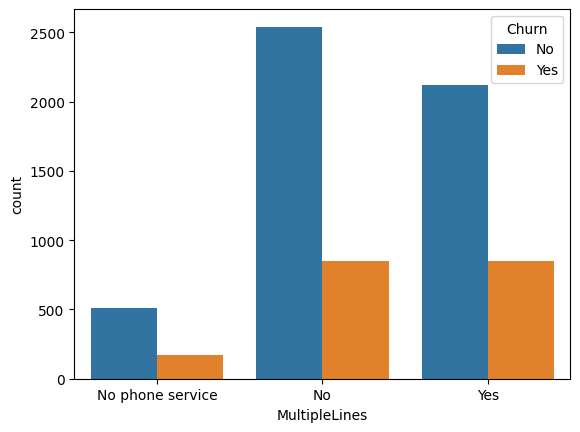



InternetService
------------------------------
                 Target Mean  Count  Ratio
InternetService                           
DSL                    0.190   2421 34.375
Fiber optic            0.419   3096 43.959
No                     0.074   1526 21.667




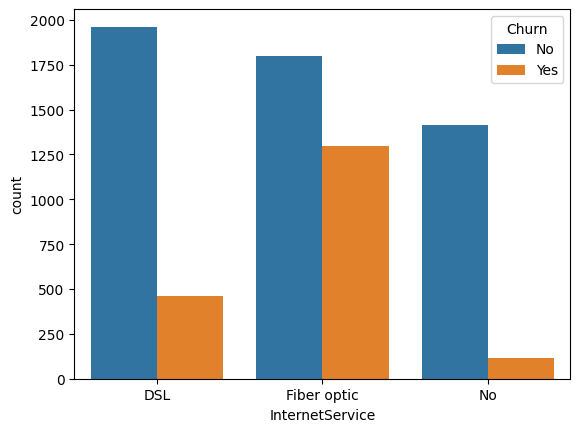



OnlineSecurity
------------------------------
                     Target Mean  Count  Ratio
OnlineSecurity                                
No                         0.418   3498 49.666
No internet service        0.074   1526 21.667
Yes                        0.146   2019 28.667




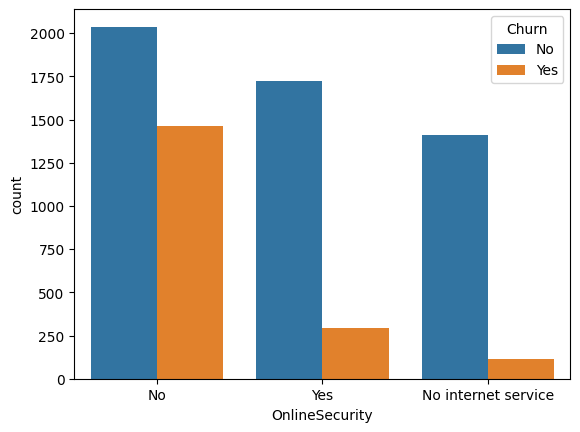



OnlineBackup
------------------------------
                     Target Mean  Count  Ratio
OnlineBackup                                  
No                         0.399   3088 43.845
No internet service        0.074   1526 21.667
Yes                        0.215   2429 34.488




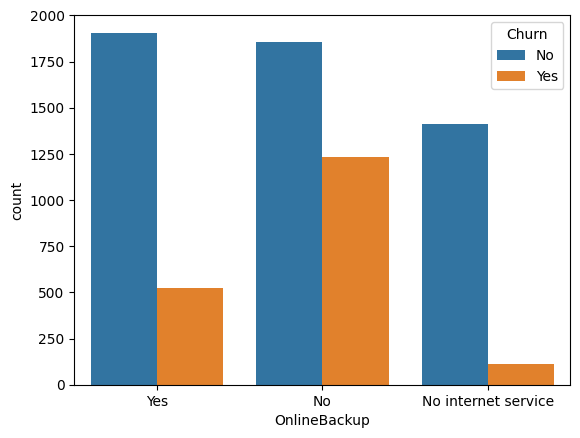



DeviceProtection
------------------------------
                     Target Mean  Count  Ratio
DeviceProtection                              
No                         0.391   3095 43.944
No internet service        0.074   1526 21.667
Yes                        0.225   2422 34.389




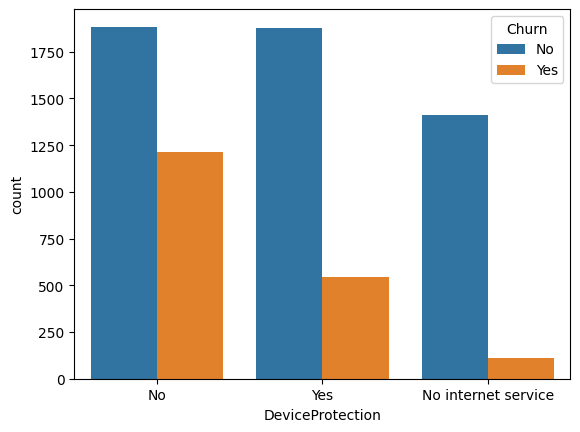



TechSupport
------------------------------
                     Target Mean  Count  Ratio
TechSupport                                   
No                         0.416   3473 49.311
No internet service        0.074   1526 21.667
Yes                        0.152   2044 29.022




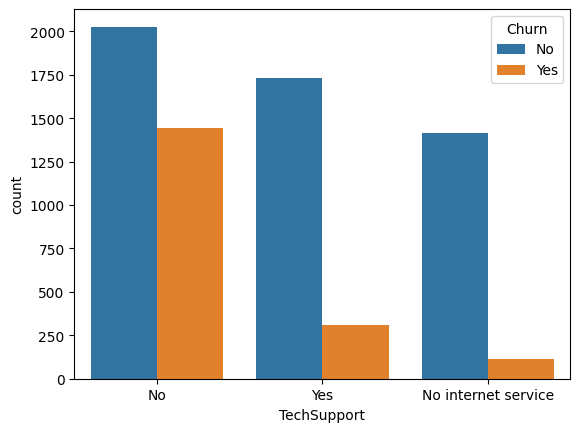



StreamingTV
------------------------------
                     Target Mean  Count  Ratio
StreamingTV                                   
No                         0.335   2810 39.898
No internet service        0.074   1526 21.667
Yes                        0.301   2707 38.435




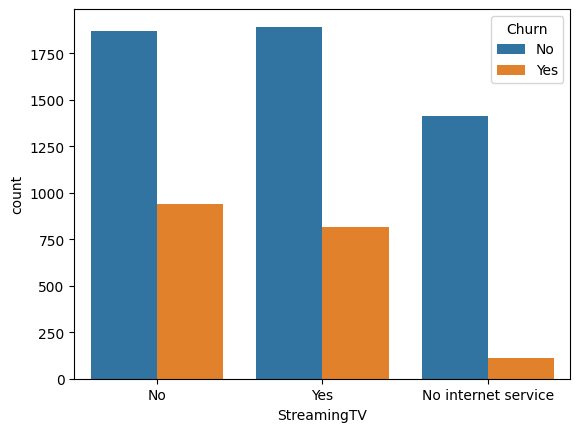



StreamingMovies
------------------------------
                     Target Mean  Count  Ratio
StreamingMovies                               
No                         0.337   2785 39.543
No internet service        0.074   1526 21.667
Yes                        0.299   2732 38.790




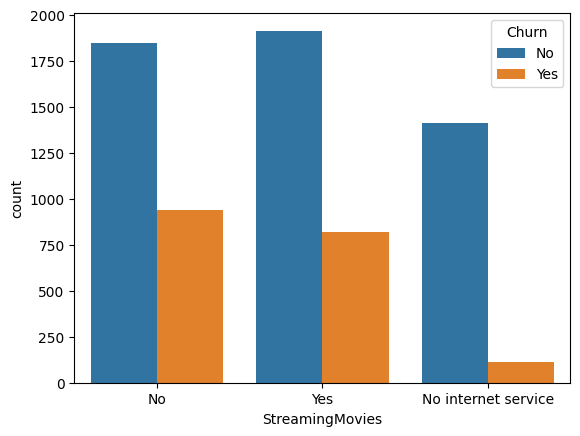



Contract
------------------------------
                Target Mean  Count  Ratio
Contract                                 
Month-to-month        0.427   3875 55.019
One year              0.113   1473 20.914
Two year              0.028   1695 24.066




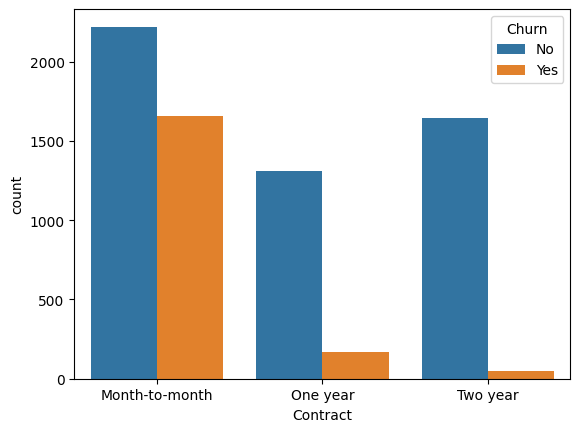



PaperlessBilling
------------------------------
                  Target Mean  Count  Ratio
PaperlessBilling                           
No                      0.163   2872 40.778
Yes                     0.336   4171 59.222




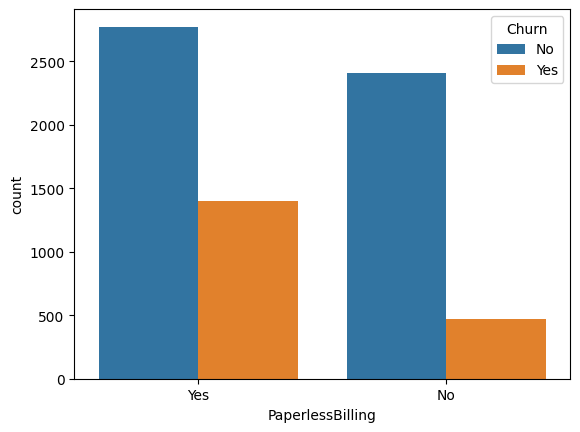



PaymentMethod
------------------------------
                           Target Mean  Count  Ratio
PaymentMethod                                       
Bank transfer (automatic)        0.167   1544 21.922
Credit card (automatic)          0.152   1522 21.610
Electronic check                 0.453   2365 33.579
Mailed check                     0.191   1612 22.888




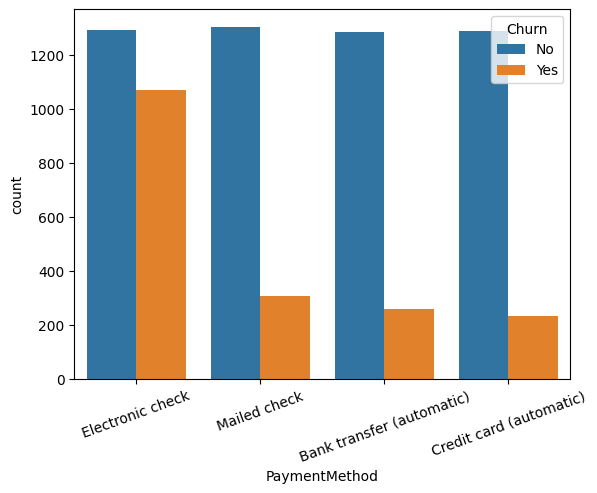



SeniorCitizen
------------------------------
               Target Mean  Count  Ratio
SeniorCitizen                           
0                    0.236   5901 83.785
1                    0.417   1142 16.215




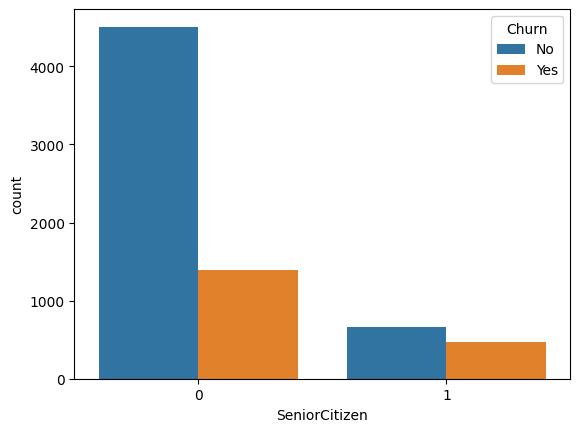

In [29]:
for col in cat_cols:
    if col == "Churn":
        continue
    target_summary_with_cat(df, "Churn", col, plot=True)

In [30]:
def target_summary_with_num(dataframe, target, numerical_col):
    """
    This function shows the average of the numerical variables according to the target variable.

    Parameters
    ------
        dataframe (dataframe): The dataframe to be processed.
        target (str): Target variable.
        numerical_col (str): Numerical variables list.
    """
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [31]:
for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




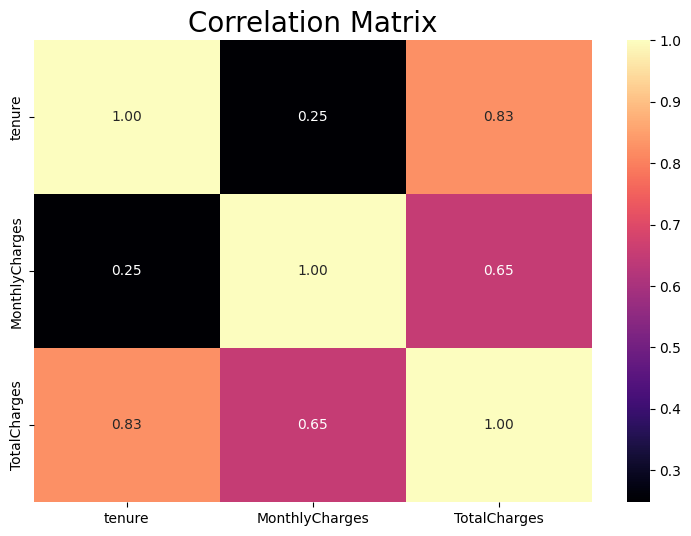

In [32]:
f, ax = plt.subplots(figsize=[9, 6])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [33]:
df[num_cols].corrwith(df["Churn"]).sort_values(ascending=False)

MonthlyCharges    0.193
TotalCharges     -0.199
tenure           -0.352
dtype: float64

In [34]:
def missing_values_table(dataframe, na_name=False):
    """
    This function is used to examine missing values.

    Parameters
    ------
        dataframe (dataframe): The dataframe to be processed.
        na_name (bool): If True, it returns the names of the variables with missing values. Default is False.
    
    Returns
    ------
        na_columns (list): Variables with missing values (if na_name=True).
    """

    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [35]:
na_columns = missing_values_table(df, na_name=True)

              n_miss  ratio
TotalCharges      11  0.160


In [36]:
df[df["TotalCharges"].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,NaN,0


In [37]:
df["TotalCharges"].fillna(0, inplace=True)

In [38]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    """
    This function is used to set the lower and upper limits for outliers.

    Parameters
    ------
        dataframe (dataframe): The dataframe to be processed.
        col_name (str): Variable name to be processed.
        q1 (float): Lower quantile value. Default is 0.05.
        q3 (float): Upper quantile value. Default is 0.95.
    
    Returns
    ------
        low_limit (float): Lower limit value.
        up_limit (float): Upper limit value.
    """
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [39]:
def check_outlier(dataframe, col_name):
    """
    This function is used to check for outliers.

    Parameters
    ------
        dataframe (dataframe): The dataframe to be processed.
        col_name (str): Variable name to be processed.
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [40]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    """
    This function is used to replace outliers with lower and upper limits.

    Parameters
    ------
        dataframe (dataframe): The dataframe to be processed.
        variable (str): Variable name to be processed.
        q1 (float): Lower quantile value. Default is 0.05.
        q3 (float): Upper quantile value. Default is 0.95.
    """
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [41]:
print('Does column has outliers?')
for col in num_cols:
    print(f'\033[1m' +f'{col}'+'\033[0m',':', check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Does column has outliers?
tenure : False
MonthlyCharges : False
TotalCharges : False


In [42]:
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ["0-1 Year", "1-2 Year", "2-3 Year", "3-4 Year", "4-5 Year", "5-6 Year"]
df['NEW_TENURE_YEAR'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

In [43]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year


In [44]:
def feature_engineering (df):
    """
    This function is used to create new features.
    """
    # Converting tenure to year
    df["NEW_TENURE_YEAR"] = pd.cut(df["tenure"], bins=[0, 12, 24, 36, 48, 60, 72], labels=["0-1 Year", "1-2 Year", "2-3 Year", "3-4 Year", "4-5 Year", "5-6 Year"])

    # Yearly subscription flag
    df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

    # No protection services flag
    df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

    # Young and not engaged flag
    df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

    # Total number of services used
    df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                        'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                        'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

    # If the customer uses any streaming service, it is labeled as 1, otherwise 0
    df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

    # Automatic payment flag
    df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

    # Average monthly charges
    df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] )

    # Since there are customers with tenure 0, we will replace the missing values with 0
    df.loc[df["tenure"]==0, "NEW_AVG_Charges"] = 0

    # Monthly charges increase rate
    df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

    # Average service fee
    df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

    # Alone customer flag
    df["NEW_PD"] = df.apply(lambda x: 1 if (x["Partner"]== "No") & (x["Dependents"]=="No") else 0, axis=1)

    # Paperless and electronic check payment flag
    df["NEW_EP"] = df.apply(lambda x: 1 if (x["PaperlessBilling"]== "Yes") & (x["PaymentMethod"]=="Electronic check ") else 0, axis=1)
    return df

In [45]:
df = feature_engineering(df)

In [46]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043

Variables: 33

cat_cols: 26 - ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn', 'NEW_TENURE_YEAR', 'NEW_Engaged', 'NEW_noProt', 'NEW_Young_Not_Engaged', 'NEW_TotalServices', 'NEW_FLAG_ANY_STREAMING', 'NEW_FLAG_AutoPayment', 'NEW_PD', 'NEW_EP']

num_cols: 6 - ['tenure', 'MonthlyCharges', 'TotalCharges', 'NEW_AVG_Charges', 'NEW_Increase', 'NEW_AVG_Service_Fee']

cat_but_car: 1 - ['customerID']

num_but_cat: 11 - ['SeniorCitizen', 'Churn', 'NEW_TENURE_YEAR', 'NEW_Engaged', 'NEW_noProt', 'NEW_Young_Not_Engaged', 'NEW_TotalServices', 'NEW_FLAG_ANY_STREAMING', 'NEW_FLAG_AutoPayment', 'NEW_PD', 'NEW_EP']



In [47]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [48]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
print(binary_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


In [49]:
for col in binary_cols:
    df = label_encoder(df, col)

In [50]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
print(cat_cols)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'SeniorCitizen', 'NEW_TENURE_YEAR', 'NEW_Engaged', 'NEW_noProt', 'NEW_Young_Not_Engaged', 'NEW_FLAG_ANY_STREAMING', 'NEW_FLAG_AutoPayment', 'NEW_PD', 'NEW_EP']


In [51]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [52]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [53]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1,NEW_PD_1
0,7590-VHVEG,0,1,0,1,0,1,29.850,29.850,0,1,29.850,1.000,14.925,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False
1,5575-GNVDE,1,0,0,34,1,0,56.950,1889.500,0,3,55.574,0.976,14.238,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,True,False,False,False,True
2,3668-QPYBK,1,0,0,2,1,1,53.850,108.150,1,3,54.075,1.004,13.463,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,True
3,7795-CFOCW,1,0,0,45,0,0,42.300,1840.750,0,3,40.906,0.967,10.575,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,True,False,False,True,True
4,9237-HQITU,0,0,0,2,1,1,70.700,151.650,1,1,75.825,1.072,35.350,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True


In [54]:
df.columns = [col.replace(' ', '_') for col in df.columns]
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4930, 45)
(4930,)
(2113, 45)
(2113,)


In [57]:
models = {
    'CART': DecisionTreeClassifier(),
    'RF': RandomForestClassifier(),
    'GBM': GradientBoostingClassifier(),
    'XGB': XGBClassifier(),
    'LGBM': LGBMClassifier(verbose=0),
    'CATB': CatBoostClassifier(verbose=False)
}

for model_name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=False)
    print('\033[1m' +f" {model_name} ".center(30, '-') + '\033[0m')
    print('Accuracy Score: ', np.mean(scores['test_accuracy']))  # Fix: change 'accuracy' to 'test_accuracy'
    print('F1 Score: ', np.mean(scores['test_f1']))
    print('ROC AUC Score: ', np.mean(scores['test_roc_auc']))
    print('\n')

------------ CART ------------
Accuracy Score:  0.7318458417849899
F1 Score:  0.48685406641043133
ROC AUC Score:  0.6532600787071214


------------- RF -------------
Accuracy Score:  0.7912778904665314
F1 Score:  0.5455985626088204
ROC AUC Score:  0.8259483889470134


------------ GBM -------------
Accuracy Score:  0.797971602434077
F1 Score:  0.560881963086351
ROC AUC Score:  0.8376955064712973


------------ XGB -------------
Accuracy Score:  0.7791075050709939
F1 Score:  0.5385152012218747
ROC AUC Score:  0.8158577323639221


------------ LGBM ------------
Accuracy Score:  0.7870182555780934
F1 Score:  0.5519471946563563
ROC AUC Score:  0.8240269154987174


------------ CATB ------------
Accuracy Score:  0.7977687626774848
F1 Score:  0.5661403020140855
ROC AUC Score:  0.8350889305497284




In [58]:
catboost_model = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

In [59]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.8
Recall: 0.68
Precision: 0.51
F1: 0.58
Auc: 0.76


In [60]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num], hue="Feature")
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

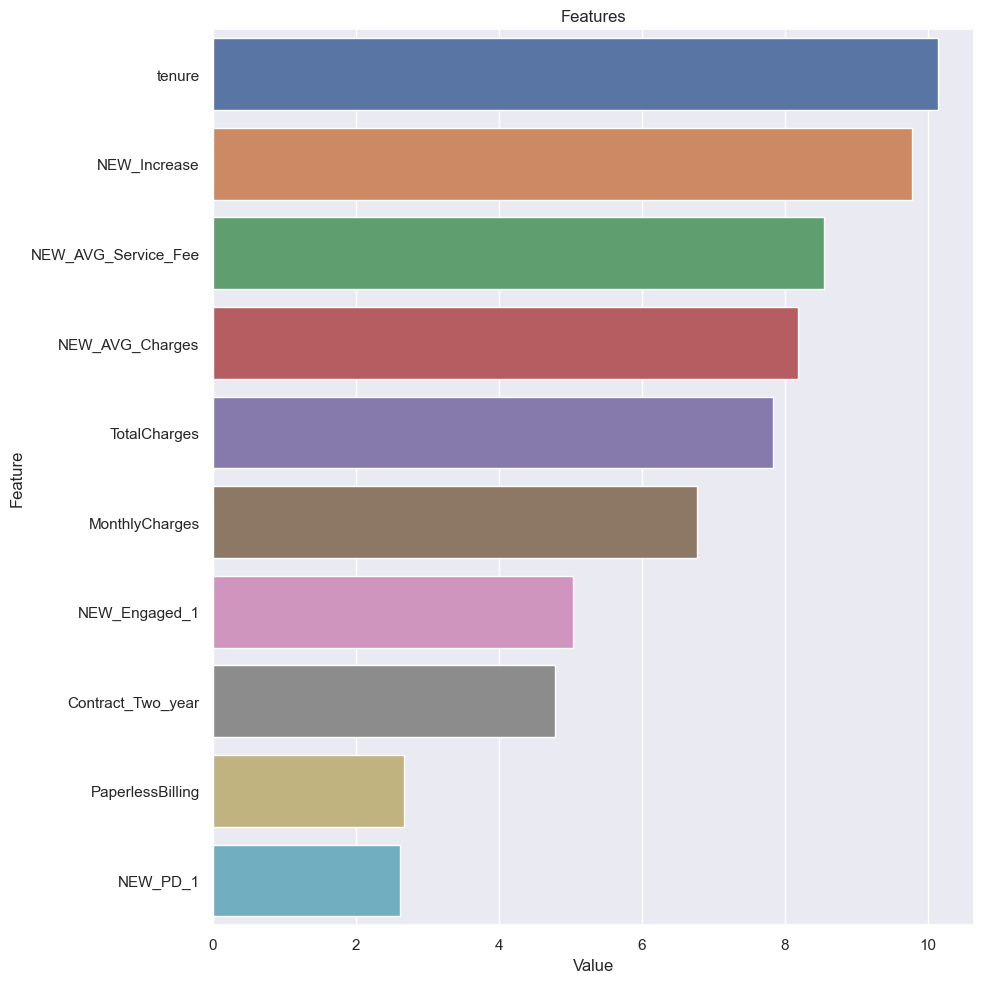

In [61]:
plot_importance(catboost_model, X_train, num=10, )

In [62]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3)
    }

    model = CatBoostClassifier(**param, verbose=False)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [63]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-04-23 20:12:03,212] A new study created in memory with name: no-name-e1cb4778-7729-4f82-ba8d-7fbbd602159f
[I 2024-04-23 20:12:11,474] Trial 4 finished with value: 0.7827733080927591 and parameters: {'iterations': 941, 'depth': 6, 'learning_rate': 0.13808411002590068}. Best is trial 4 with value: 0.7827733080927591.
[I 2024-04-23 20:12:11,604] Trial 0 finished with value: 0.7832465688594415 and parameters: {'iterations': 904, 'depth': 6, 'learning_rate': 0.23725689704999736}. Best is trial 0 with value: 0.7832465688594415.
[I 2024-04-23 20:12:20,952] Trial 7 finished with value: 0.7979176526265973 and parameters: {'iterations': 658, 'depth': 7, 'learning_rate': 0.02361920490348185}. Best is trial 7 with value: 0.7979176526265973.
[I 2024-04-23 20:12:25,153] Trial 2 finished with value: 0.7841930903928065 and parameters: {'iterations': 879, 'depth': 8, 'learning_rate': 0.19879215338933606}. Best is trial 7 with value: 0.7979176526265973.
[I 2024-04-23 20:12:28,823] Trial 5 finish

Number of finished trials: 50
Best trial: {'iterations': 507, 'depth': 7, 'learning_rate': 0.015835909439194655}


In [64]:
best_params = study.best_trial.params
catb_model = CatBoostClassifier(**best_params, verbose=False).fit(X_train, y_train)

In [65]:
prediction = catb_model.predict(X_test)

In [66]:
print(f"Accuracy: {round(accuracy_score(prediction, y_test), 2)}")
print(f"Recall: {round(recall_score(prediction,y_test),2)}")
print(f"Precision: {round(precision_score(prediction,y_test), 2)}")
print(f"F1: {round(f1_score(prediction,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(prediction,y_test), 2)}")

Accuracy: 0.81
Recall: 0.69
Precision: 0.51
F1: 0.59
Auc: 0.76


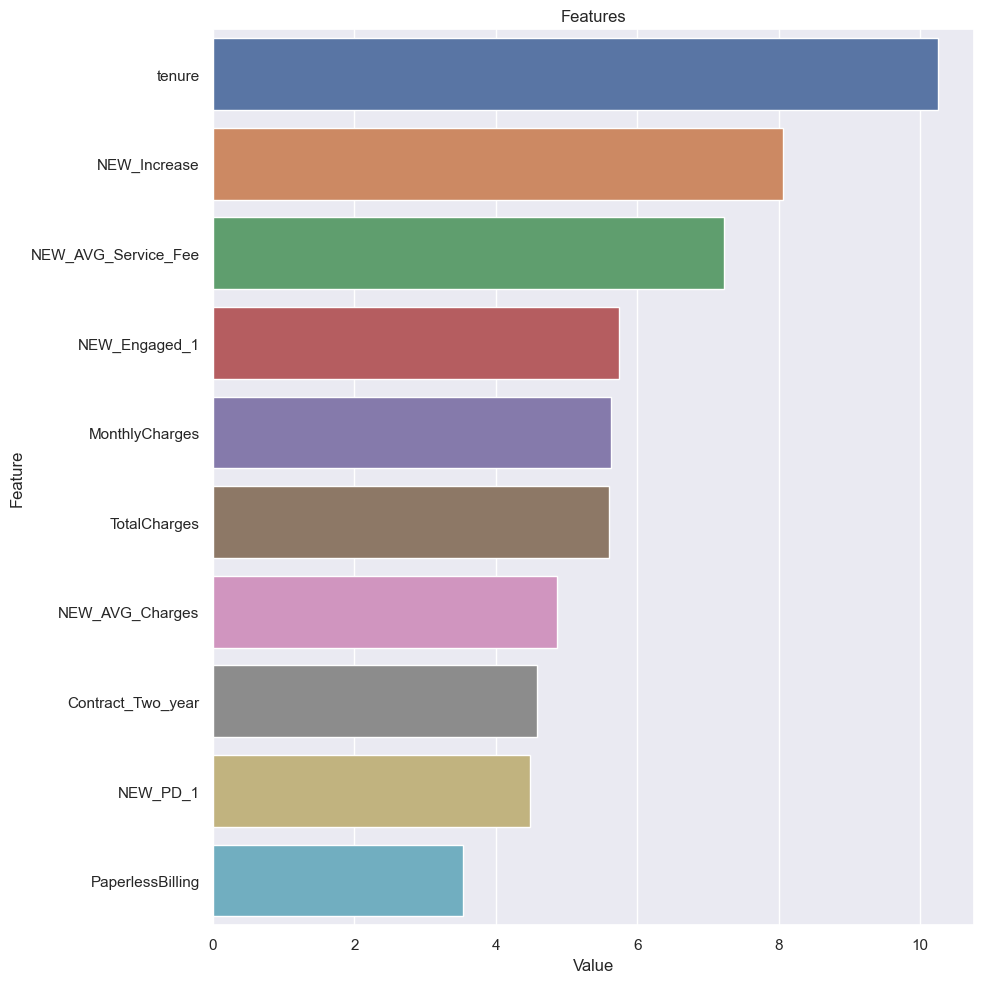

In [67]:
plot_importance(catb_model, X_train, num=10)